# **Import Libraries**

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import dash
import numpy as np
import warnings

# **Data Preparation**

In [50]:
try:
    df = pd.read_excel('V02.01.xlsx', sheet_name='V02.01', skiprows=2)
    df.rename(columns={df.columns[0]: f'C'}, inplace=True)
except:
    print('File not found')

for i in range(1,len(df.columns),3):
    df.rename(columns={df.columns[i+1]: f'{df.columns[i]}'}, inplace=True)
    df.rename(columns={df.columns[i+2]: f'{df.columns[i]}'}, inplace=True)
total = []
for i in range(1, len(df.columns), 3):
    df1 = pd.DataFrame()
    df1['City'] = df.iloc[1:, 0]
    df1['Diện tích(Km2)'] = df.iloc[1:,i]
    df1['Dân số trung bình (Nghìn người)'] = df.iloc[1:,i+1]
    df1['Mật độ dân số (Người/km2)'] = df.iloc[1:,i+2]
    df1['Year'] = df.columns[i].replace(' (*)','')
    total.append(df1)

total = pd.concat(total)
total.to_excel('V02.0101.xlsx', index=False)
total.head()

,City,Diện tích(Km2),Dân số trung bình (Nghìn người),Mật độ dân số (Người/km2),Year
1,CẢ NƯỚC,330957.6,87860.4,265.47,2011
2,Đồng bằng sông Hồng,21068.1,20066.1,952.44,2011
3,Hà Nội,3328.9,6761.3,2031.09,2011
4,Vĩnh Phúc,1236.5,1011.4,817.95,2011
5,Bắc Ninh,822.7,1063.4,1292.57,2011


# **EDA**

In [51]:
df = total.copy()

,count,unique,top,freq
City,840,70,CẢ NƯỚC,12
Diện tích(Km2),840.0,410.0,3536.7,9.0
Dân số trung bình (Nghìn người),840.0,830.0,1215.2,2.0
Mật độ dân số (Người/km2),840,629,108,6
Year,840,12,2011,70


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 1 to 70
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   City                             840 non-null    object
 1   Diện tích(Km2)                   840 non-null    object
 2   Dân số trung bình (Nghìn người)  840 non-null    object
 3   Mật độ dân số (Người/km2)        840 non-null    object
 4   Year                             840 non-null    object
dtypes: object(5)
memory usage: 39.4+ KB


In [53]:
df['Diện tích(Km2)'] = df['Diện tích(Km2)'].astype(float)
df['Dân số trung bình (Nghìn người)'] = df['Dân số trung bình (Nghìn người)'].astype(float)
df['Mật độ dân số (Người/km2)'] = df['Mật độ dân số (Người/km2)'].astype(float)
df['Year'] = df['Year'].astype(int)
year_list = df['Year'].unique()
area_list = ['CẢ NƯỚC', 'Tây Nguyên', 'Đông Nam Bộ', 'Đồng bằng sông Hồng', 'Trung du và miền núi phía Bắc', 'Bắc Trung Bộ và Duyên hải miền Trung', 'Đồng bằng sông Cửu Long']
real_data = df.copy()

for area in area_list:
    df.drop(df[df['City'] == area].index, inplace=True)
city_list = df['City'].unique()[1:]
city_list

array(['Vĩnh Phúc', 'Bắc Ninh', 'Quảng Ninh', 'Hải Dương', 'Hải Phòng',
       'Hưng Yên', 'Thái Bình', 'Hà Nam', 'Nam Định', 'Ninh Bình',
       'Hà Giang', 'Cao Bằng', 'Bắc Kạn', 'Tuyên Quang', 'Lào Cai',
       'Yên Bái', 'Thái Nguyên', 'Lạng Sơn', 'Bắc Giang', 'Phú Thọ',
       'Điện Biên', 'Lai Châu', 'Sơn La', 'Hoà Bình', 'Thanh Hoá',
       'Nghệ An', 'Hà Tĩnh', 'Quảng Bình', 'Quảng Trị', 'Thừa Thiên Huế',
       'Đà Nẵng', 'Quảng Nam', 'Quảng Ngãi', 'Bình Định', 'Phú Yên',
       'Khánh Hoà', 'Ninh Thuận', 'Bình Thuận', 'Kon Tum', 'Gia Lai',
       'Đắk Lắk', 'Đắk Nông', 'Lâm Đồng', 'Bình Phước', 'Tây Ninh',
       'Bình Dương', 'Đồng Nai', 'Bà Rịa - Vũng Tàu', 'TP.Hồ Chí Minh',
       'Long An', 'Tiền Giang', 'Bến Tre', 'Trà Vinh', 'Vĩnh Long',
       'Đồng Tháp', 'An Giang', 'Kiên Giang', 'Cần Thơ', 'Hậu Giang',
       'Sóc Trăng', 'Bạc Liêu', 'Cà Mau'], dtype=object)

# **Question 1:** Dùng biểu đồ line biểu diễn tỉ lệ tăng dân số trung bình của các năm của các tỉnh có tỉ lệ tăng nhanh nhất

In [54]:
def grown_rate(data: pd.DataFrame, city: str, year_first, year_last) -> tuple:
    return city, (data[(data['City'] == city) & (data['Year'] == year_last)]['Dân số trung bình (Nghìn người)'].values[0] - data[(data['City'] == city) & (data['Year'] == year_first)]['Dân số trung bình (Nghìn người)'].values[0])/(year_list[-1] - year_list[0])
sorted_grown_rate = sorted([grown_rate(df, i, year_list[0], year_list[-1]) for i in city_list], reverse=True, key=lambda x: x[1])

<Axes: xlabel='index'>

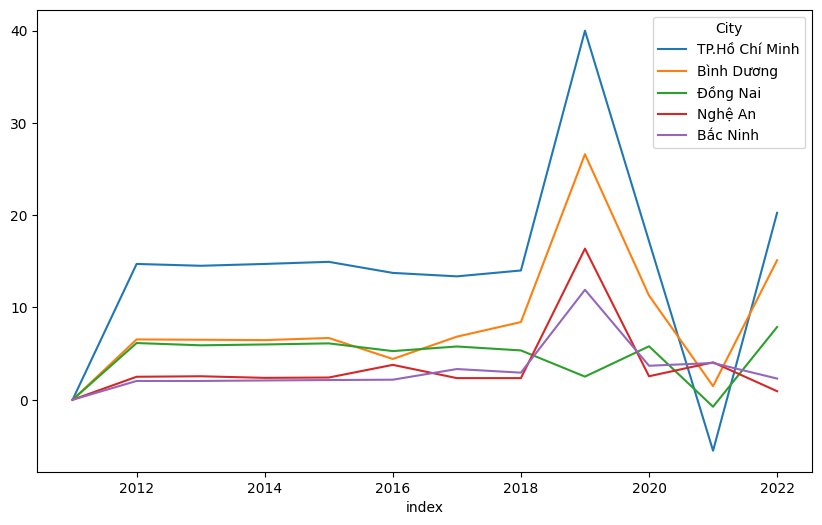

In [55]:
ctlist = []
for x in sorted_grown_rate:
    ct,_ = x
    ctlist.append(ct)
ctlist[:5]

data = pd.DataFrame(np.array(ctlist[:5]),columns=['City'])

for year in year_list:
    if year == year_list[0]:
        data[year] = 0
    else:
        ratelist = []
        for city in ctlist[:5]:
            ratelist.append(grown_rate(df,city, year-1, year)[1])
        data[year] = ratelist
data.set_index('City', inplace=True)
data = data.T.reset_index()
data.plot(kind='line', x = 'index', figsize=(10,6))

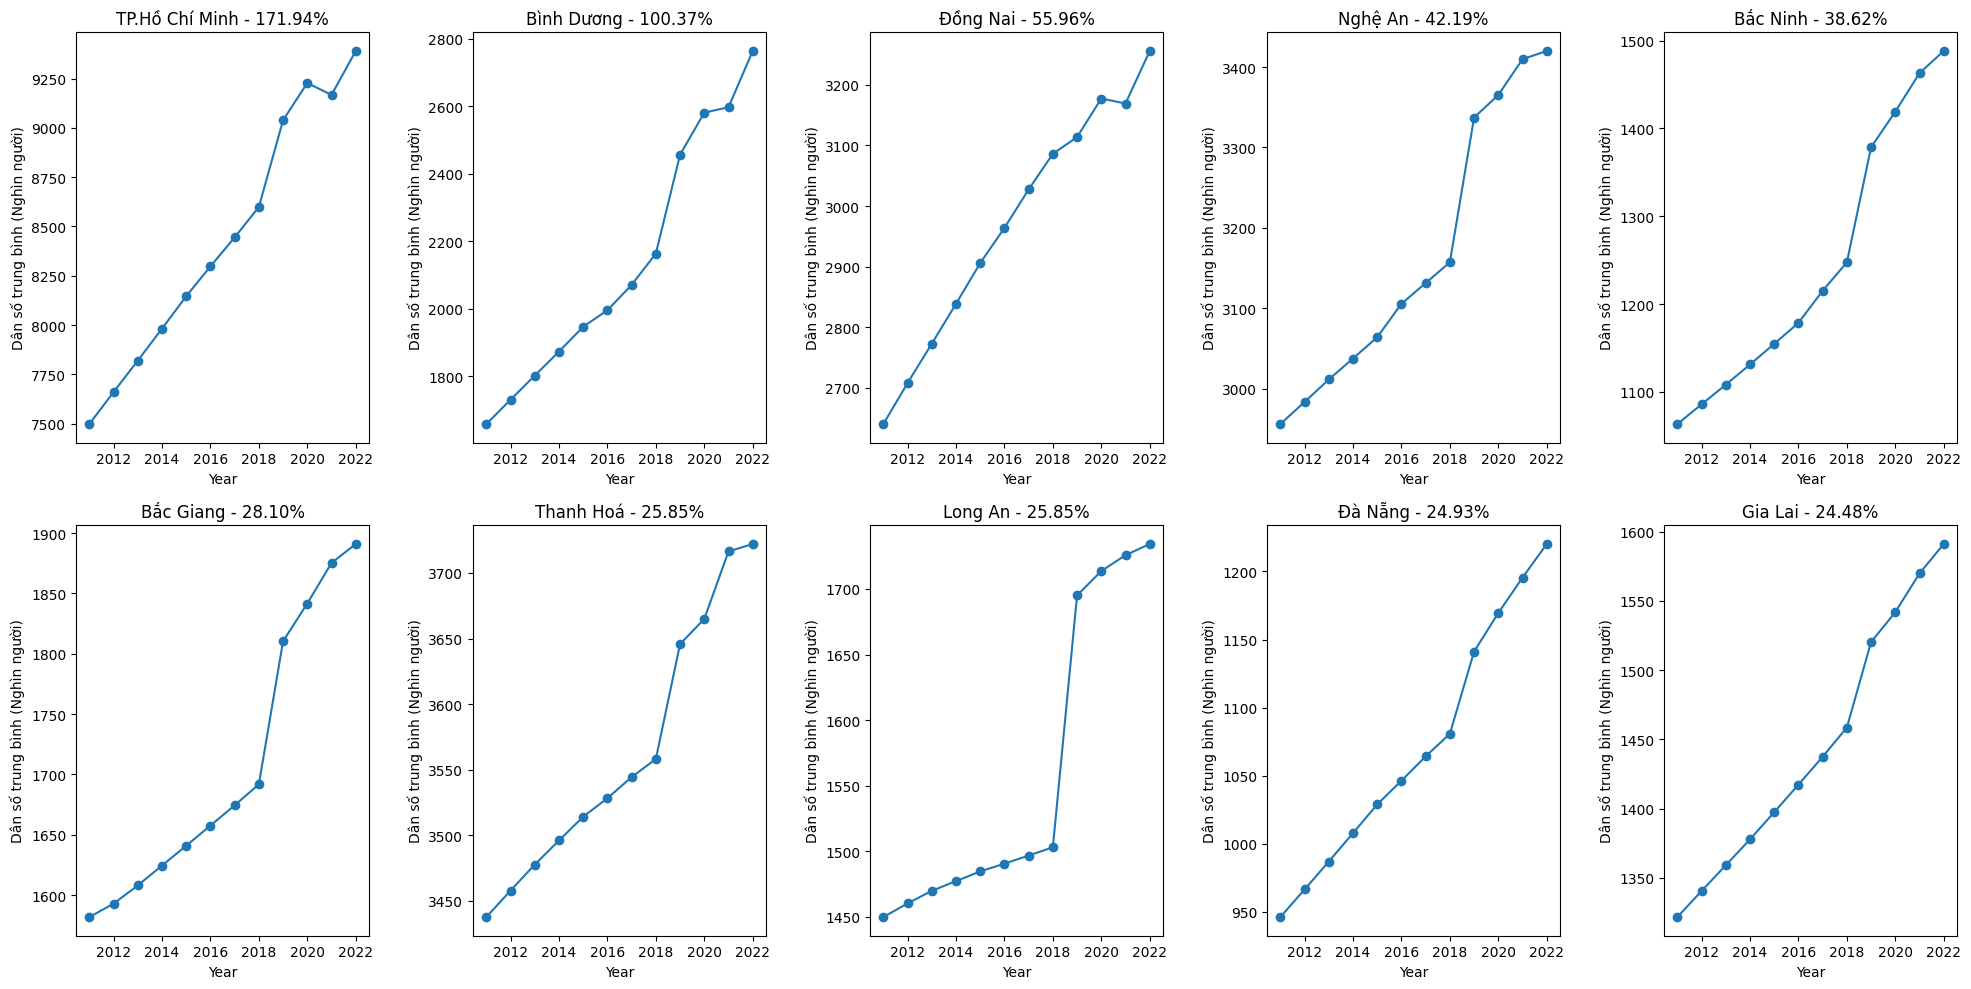

In [56]:
plt.figure(figsize=(20, 10))
for index, item in enumerate(sorted_grown_rate[:10]):
    city, rate = item
    data = df[df['City'] == city]
    plt.subplot(2, 5, index+1)
    plt.title(f'{city} - {rate:.2f}%')
    plt.plot(data['Year'], data['Dân số trung bình (Nghìn người)'], marker='o')
    plt.xlabel('Year')
    plt.ylabel('Dân số trung bình (Nghìn người)')


plt.tight_layout()
plt.show()

# **Question 2:** Biểu đồ Bar mô tả dân số ở 5 tỉnh có mật độ dân số cao nhất

In [57]:
df.groupby('City').mean().sort_values(by='Mật độ dân số (Người/km2)', ascending=False).reset_index().head(5)[['City','Mật độ dân số (Người/km2)']]

,City,Mật độ dân số (Người/km2)
0,TP.Hồ Chí Minh,4050.017500
1,Hà Nội,2248.789167
2,Bắc Ninh,1512.616667
3,Hải Phòng,1292.656667
4,Hưng Yên,1291.710833


In [58]:
data = pd.DataFrame(year_list, columns=['Year'])
for index, city in enumerate(df[df['City'] != 'CẢ NƯỚC'].groupby('City').mean().sort_values(by='Diện tích(Km2)', ascending=False).reset_index().head(5)['City'].to_list()):
    data[city] = df[df['City'] == city].sort_values(by='Year', ascending=True).reset_index()['Mật độ dân số (Người/km2)'].values

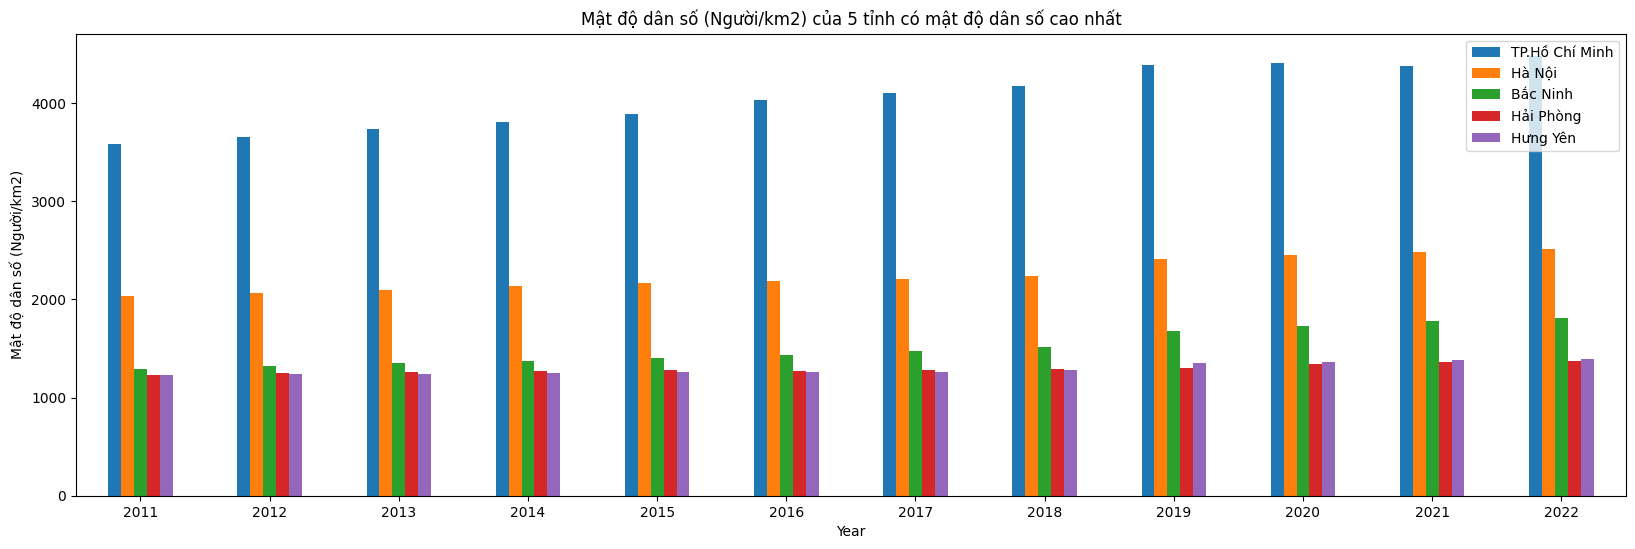

In [59]:
data = pd.DataFrame(year_list, columns=['Year'])
for index, city in enumerate(df.groupby('City').mean().sort_values(by='Mật độ dân số (Người/km2)', ascending=False).reset_index().head(5)['City'].to_list()):
    data[city] = df[df['City'] == city].sort_values(by='Year', ascending=True).reset_index()['Mật độ dân số (Người/km2)'].values
data.set_index('Year', inplace=True)
data.plot(kind='bar', stacked=False, figsize=(20, 6))
plt.xticks(rotation=0)
plt.xlabel('Year')
plt.ylabel('Mật độ dân số (Người/km2)')
plt.title('Mật độ dân số (Người/km2) của 5 tỉnh có mật độ dân số cao nhất')
plt.show()

# **Question 3:** Dùng biểu đồ Area biểu diễn tỉ lệ tăng dân số của các năm của 5 thành phố có diện tích lớn nhất

In [60]:
# Largest City
df[df['City'] != 'CẢ NƯỚC'].groupby('City').mean().sort_values(by='Diện tích(Km2)', ascending=False).reset_index().head(5)

,City,Diện tích(Km2),Dân số trung bình (Nghìn người),Mật độ dân số (Người/km2),Year
0,Nghệ An,16486.924167,3164.825000,191.891667,2016.5
1,Gia Lai,15521.555000,1444.369167,93.069167,2016.5
2,Sơn La,14141.288333,1211.917500,85.676667,2016.5
3,Đắk Lắk,13080.018333,1861.581667,142.373333,2016.5
4,Thanh Hoá,11121.343333,3563.644167,320.407500,2016.5


Text(0, 0.5, 'Dân số trung bình (Nghìn người)')

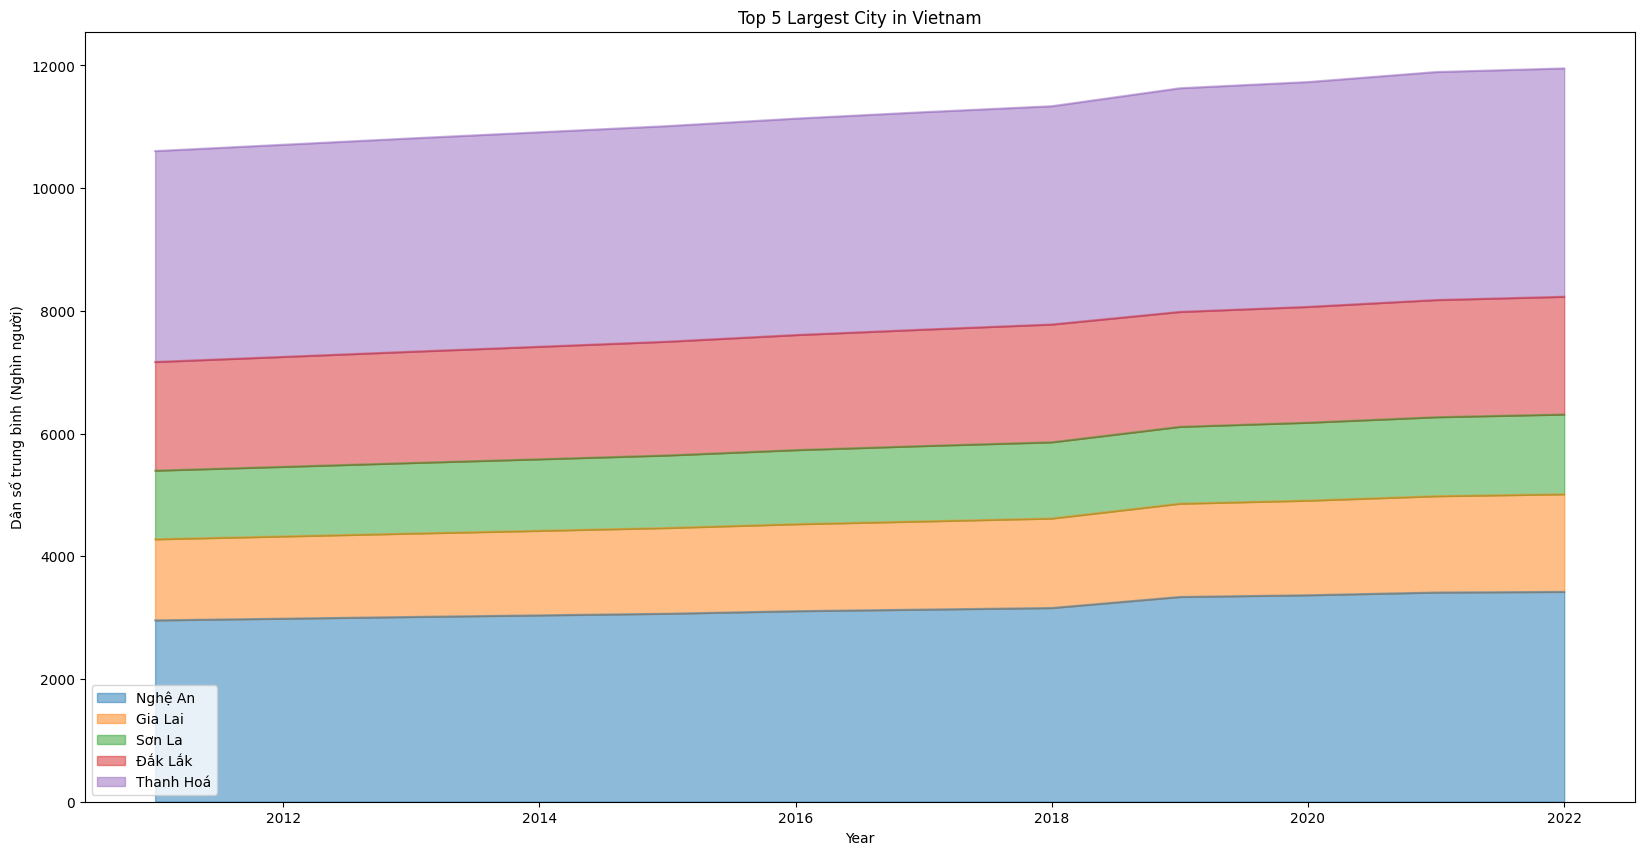

In [61]:

data = pd.DataFrame(year_list, columns=['Year'])
for index, city in enumerate(df[df['City'] != 'CẢ NƯỚC'].groupby('City').mean().sort_values(by='Diện tích(Km2)', ascending=False).reset_index().head(5)['City'].to_list()):
    data[city] = df[df['City'] == city].sort_values(by='Year', ascending=True).reset_index()['Dân số trung bình (Nghìn người)'].values
data.set_index('Year', inplace=True)
data.plot(kind='area', stacked=True, figsize=(20, 10), alpha=0.5)
plt.title('Top 5 Largest City in Vietnam')
plt.xlabel('Year')
plt.ylabel('Dân số trung bình (Nghìn người)')


# **Question 4:** pie charts: biểu diễn tỉ lệ dân số của các khu vực trong năm 2013

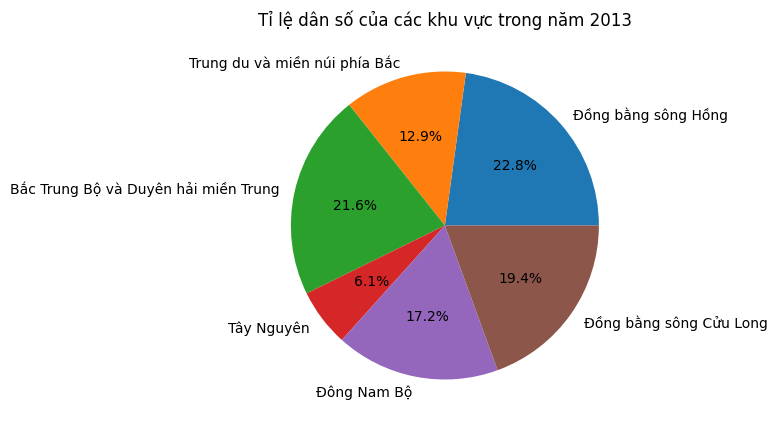

In [62]:
# real_data = pd.real_dataFrame(columns=[['City','Dân số trung bình (Nghìn người)']])
data = real_data[(real_data['City'].isin(area_list[1:])) & (real_data['Year'] == 2013)][['City','Dân số trung bình (Nghìn người)','Year']]
data.set_index('City', inplace=True)
data.plot(kind='pie', y='Dân số trung bình (Nghìn người)', figsize=(5,5), x='City', legend=False, ylabel='', autopct='%1.1f%%', title='Tỉ lệ dân số của các khu vực trong năm 2013');

# **Question 5:** Choropleth Maps with Folium: mô tả tình trạng phân bố của các tỉnh lên bảng đồ

In [89]:
import json

# Load the GeoJSON data for the map
with open('./vietnam.geojson', 'r', encoding='utf-8') as file:
    geojson_data = json.load(file)

# Load the data for the choropleth
data = df.copy()

# Create a Folium map object
m = folium.Map(location=[15,106], zoom_start=6)

# Create the choropleth layer
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=data,
    columns=['City', 'Mật độ dân số (Người/km2)'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Legend'
).add_to(m)

# Add a layer control to the map
folium.LayerControl().add_to(m)

# Display the map
m


# **Question 6:** Xây dựng Dashboards with Potly and Dash: 
- Chọn năm: hiển thị tình hình biến động dân số của các tỉnh thành, tỉ lệ tăng dân số của các tỉnh thành trong năm
- chọn tỉnh thành biểu diễn tình hình tăng dân số theo các năm. biểu diễn tỉ lệ tăng dân số theo tỉnh thành

In [65]:
import dash
from dash import dcc, html, callback_context
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div(children=[
    html.Div(children=[
    html.H1(children='Chọn năm: hiển thị tình hình biến động dân số của các tỉnh thành, tỉ lệ tăng dân số của các tỉnh thành trong năm',
            style={
                'textAlign': 'center',
                'boxShadow': '0px 2px 4px rgba(0, 0, 0, 0.2)',
                'backgroundColor': '#f2f2f2',
                'borderRadius': '10px',
                'padding': '10px',
                'width': '90%'

            }
            ),

    html.Div(children='''
        Giờ chọn năm bắt đầu đi bạn
    ''',
    style={
        'textAlign': 'center',
        'boxShadow': '0px 2px 4px rgba(0, 0, 0, 0.2)',
        'backgroundColor': '#f2f2f2',
        'borderRadius': '10px',
        'padding': '10px',
        'width': '70%',
    }
    )],
    style={
        'width': '100%',
        'align-items': 'center',
        'justify-content': 'center',
        'display': 'flex',
        'flex-direction': 'column'
    }

    ),
    html.Script(),
    html.Div(
        children=[
        dcc.Dropdown(
            id='year-dropdown-first',
            options=[
                {'label': str(year), 'value': year} for year in df['Year'].unique()
            ],
            value=df['Year'].min(),
            style={
                'width': '100%'
            }  # Default value is the maximum year
        ),
        dcc.Dropdown(
            id='year-dropdown-last',
            options=[
                {'label': str(year), 'value': year} for year in df['Year'].unique()
            ],
            value=df['Year'].max(),
            style={
                'width': '100%'
            }  # Default value is the maximum year
        )
        ],
        style={
            'width': '100%', 
            'align-items': 'center',
            'justify-content': 'center',
            'display': 'flex',
            'flex-direction': 'row'
            }
    ),

    html.Div(children=[

        html.Div(children=[dcc.Checklist(options=[{'label': item, 'value': item} for item in city_list], id='city-checklist', style={
            'width': '50%',
            'height': '300px',
            'border': '1px solid black',
            'padding': '10px',
            'margin': '10px',
            'borderRadius': '10px',
            'display': 'flex',
            'flex-wrap': 'wrap',
            'flex-direction': 'row',
        }
        )], id='Box 1', style={
            'display': 'flex',
            'justify-content': 'center',
            'align-items': 'center',
            }),

    ],
    style={
        'width': '100%',
        'align-items': 'center',
        'justify-content': 'center',
        'display': 'flex',
        'flex-direction': 'row',
        'backgroundColor': '#f2f2f2',
    }    
    ),
    dcc.Graph(
        id='population-graph'
    ),
    dcc.Graph(
        id='grown-rate-graph'
    )
])

# Define callback to update the graph based on the selected year
@app.callback(
    Output('population-graph', 'figure'),
    [Input('year-dropdown-first', 'value'), Input('year-dropdown-last', 'value'), Input('city-checklist', 'value')]
)
def update_graph(selected_year_first, selected_year_last, selected_cities):
    try:
        filtered_df = df[(df['Year'] < max(selected_year_first, selected_year_last)) & (df['Year'] > min(selected_year_first, selected_year_last)) & (df['City'].isin(selected_cities))]
        fig = px.line(filtered_df, x='Year', y='Dân số trung bình (Nghìn người)', color='City', title=f'Sample Bar Chart for {min(selected_year_first, selected_year_last)} - {max(selected_year_first, selected_year_last)}')
     
    except:
        fig = px.line()
    return fig
@app.callback(
    Output('grown-rate-graph', 'figure'),
    [Input('year-dropdown-first', 'value'), Input('year-dropdown-last', 'value'), Input('city-checklist', 'value')]
)
def update_graph(selected_year_first, selected_year_last, selected_cities):
    try:
        filtered_df = df[(df['Year'] <= selected_year_last) & (df['Year'] >= selected_year_first) & (df['City'].isin(selected_cities))]
        filtered_df['Rate'] = 0
        for city in selected_cities:
            for year in year_list[1:]:
                filtered_df.loc[(filtered_df['City'] == city) & (filtered_df['Year'] == year), 'Rate'] = grown_rate(filtered_df, city, year-1, year)[1]

        fig = px.line(filtered_df, x='Year', y='Rate', color='City', title='Tỉ lệ tăng dân số của các tỉnh thành trong năm')
    except:
        fig = px.line()
    return fig
if __name__ == '__main__':
    app.run_server(debug=True)
